In [1]:
from google.colab import drive
drive.mount('/content/drive/')
%cd drive/My \Drive/Sem \8 \files/
!ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/
/content/drive/My Drive/Sem 8 files
 data				  __pycache__
 euclidean_distances.json	  Shortest_path_lengths.pkl
'Fri Feb 14 09_06_16 2020.json'   utils.py


In [2]:
!apt-get install -y libspatialindex-c4v5
!pip3.6 install osmnx

import osmnx as ox
import networkx as nx
import pandas as pd
import json
import random
import statistics
import matplotlib.pyplot as plt
import numpy as np

from rtree import index
from utils import *

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libspatialindex4v5
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex4v5
0 upgraded, 2 newly installed, 0 to remove and 25 not upgraded.
Need to get 270 kB of archives.
After this operation, 1,107 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-c4v5 amd64 1.8.5-5 [51.7 kB]
Fetched 270 kB in 2s (130 kB/s)
Selecting previously unselected package libspatialindex4v5:amd64.
(Reading database ... 144568 files and directories currently installed.)
Preparing to unpack .../libspatialindex4v5_1.8.5-5_amd64.deb ...
Unpacking libspatialindex4v5:amd64 (1.8.5-5) ...
Selecting previously unselected package libspatialindex-c4v5:amd64.
Preparing to u

In [3]:
place_name = "Singapore, Central, Singapore"
G = ox.save_load.load_graphml(filename="Singapore_drive_processed.graphml")

# Stores nodes and edges mapped with speed bands along with other attributes
type(G)

networkx.classes.multidigraph.MultiDiGraph

In [0]:
edges = ox.graph_to_gdfs(G, nodes=False, edges=True)
nodes = pd.read_pickle('data/nodes_drive.pkl')

In [5]:
f = open("Fri Feb 14 09_06_16 2020.json", "r").read()
x = json.loads(f)

speed_bands = pd.DataFrame.from_dict(x, orient='columns')
process_speed_band(speed_bands)

/content/drive/My Drive/Sem 8 files/utils.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MaximumSpeed'][i] = '80'


In [0]:
calculate_congestion(G, edges, speed_bands)

In [0]:
# Filter out all bus stop nodes
# key: node label ,value: location
idx = index.Index()

xx = nodes['x'].astype(float)
yy = nodes['y'].astype(float)
node_id = nodes['osmid']
node_type = nodes['highway']

# nan = 18823

# speed_camera = 2
# motorway_junction = 222
# turning_circle = 79
# crossing = 27
# turning_loop = 26
# mini_roundabout = 6
# traffic signals = 4031

for node, x, y, kind in zip(node_id, xx, yy, node_type):
    if type(kind) == float:
      idx.insert(int(node), (x,y,x,y))

### Showing that the shortest distance may not be the least congested path always.

In [0]:
def find_nearest_nodes(nodes, source, dist, idx):
    # Create a bounding box around source of min distance in all directions
    (north, south, east, west) = ox.bbox_from_point(point=source, distance=dist)
    
    candidate_nodes = []
    initial = list(idx.intersection((west, south, east, north)))   
    for node in initial:
      x = haversine_distance(nodes, node, source)
      if x <= dist:
        candidate_nodes.append(node)

    return candidate_nodes

In [0]:
def get_length_dict(sources, destinations, method='euclidean'):
    distances = dict()
    
    if method == 'euclidean':
        for source in sources:        
            for dest in destinations:
                ed = haversine_distance(nodes, source, dest)
                distances[source,dest] = ed/13.8889
    elif method == 'hybrid':
        for source in sources:        
            for dest in destinations:
                try:
                    # dijsktra distance in sec
                    d = nx.shortest_path_length(G, source, dest, weight='BPR', method='dijkstra')
                except nx.NetworkXUnfeasible:
                    d = float('inf')
                distances[(source,dest)] = d
    elif method == 'dijkstra':
        for source in sources:
            for dest in destinations:
                try:
                    # dijsktra distance in metres
                    d = nx.shortest_path_length(G, source, dest, weight='length', method='dijkstra')
                except nx.NetworkXUnfeasible:
                    d = float('inf')
                distances[(source,dest)] = d
       
    # sort the dictionary in ascending order using distances
    x = sorted(distances.items(), key = lambda kv:(kv[1], kv[0]))
    return x    

In [0]:
def lets_do_this():
  # get 10 random sources
  sources = []
  for i in range(10):
      r = random.randint(0,23210)
      s = nodes['osmid'].values[r]
      sources.append(s)
      
  # get 10 correspondig random targets
  targets = []
  for i in range(10):
      r = random.randint(0,23210)
      t = nodes['osmid'].values[r]
      targets.append(t)

  hybrid = []
  exhaustive = []
  for s,t in zip(sources,targets):
      orig_point = nodes[nodes['osmid'] == s].geometry.values[0]
      target_point = nodes[nodes['osmid'] == t].geometry.values[0]
      orig_xy = (orig_point.y, orig_point.x)
      target_xy = (target_point.y, target_point.x)
      
      # Max distance for walking is 720m (10 min * 1.2 m/s)
      # Find all nodes within 720 m from candidate sources and candidate destinations
      candidate_dest = find_nearest_nodes(nodes, target_xy, 500, idx)
      candidate_source = find_nearest_nodes(nodes, orig_xy, 500, idx)

      if len(candidate_dest) == 0:
        candidate_dest.append(ox.get_nearest_node(G, target_xy))
      
      if len(candidate_source) == 0:
        candidate_source.append(ox.get_nearest_node(G, orig_xy))
      
      tape_lengths = dict(get_length_dict(candidate_source, candidate_dest, method='dijkstra'))
      real_lengths = dict(get_length_dict(candidate_source, candidate_dest, method='hybrid'))
      euclidean = get_length_dict(candidate_source, candidate_dest)
      
      # value1: hybrid (in secs), value2: exhaustive tape length travel time (in secs)
      value1 = hybrid_search_length(G, euclidean, real_lengths)
      hybrid.append(value1)

      key = next(iter(tape_lengths))    
      value2 = real_lengths[(key[0], key[1])]
      exhaustive.append(value2)

      print(s, t, value1, value2)
      
  # return travel times
  return hybrid, exhaustive

In [11]:
hybrid, exhaustive = lets_do_this()

4868234655 1318514087 2746.9503441677525 5430.75631638578
3736513310 2674329547 4790.702397248608 9560.700984672627
6273396368 5214956045 262.48332789889855 1169.5243778550505
1845246503 6047755848 2686.5565785484846 3115.6053887749026
1849457982 4598835264 768.4147241507226 769.2457163504603
241598308 5256723273 2140.7260924989846 155735.09184564374
1637003430 2577843872 2795.8482121361462 3211.1113277158065
2385488983 1711614613 2399.627973597399 3675.6843504395597
4605000856 4600582772 6165.9878930517925 6165.9878930517925
1360143410 4713792476 745.402867368042 501305.82250181044


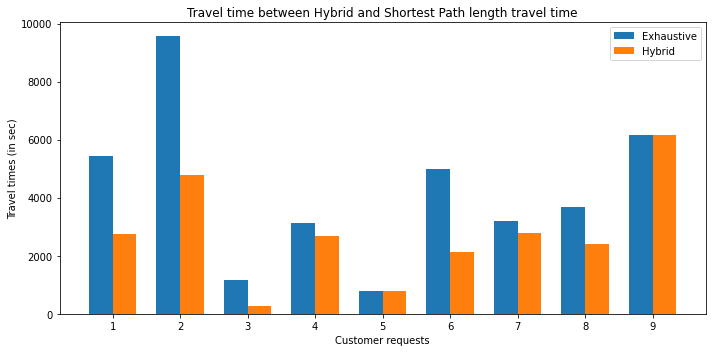

In [20]:
# Plot them

labels = [x for x in range(1,10)]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10,5))
rects1 = ax.bar(x - width/2, exhaustive[:-1], width, label='Exhaustive')
rects2 = ax.bar(x + width/2, hybrid[:-1], width, label='Hybrid')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Travel times (in sec)')
ax.set_xlabel('Customer requests')
ax.set_title('Travel time between Hybrid and Shortest Path length travel time')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()